In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import TradingGameEnv
import baseline_agents
from stable_baselines import PPO2
from stable_baselines.common.evaluation import evaluate_policy
from os import listdir
from os.path import isfile, join

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# we need to use the same settings as the env used in training. Otherwise the agent may be confused.
NUM_PLAYERS = 2
SEQ_PER_DAY = 2
CARDS_PER_SUIT = 10
SUIT_COUNT = 1
BETTING_MARGIN = CARDS_PER_SUIT*CARDS_PER_SUIT/100
EVAL_EPISODES = int(1e3)
TRANSACTION_HISTORY_SIZE = 4

HAND_COUNT = (int) ((CARDS_PER_SUIT)/2*SUIT_COUNT/NUM_PLAYERS)

PUBLIC_CARDS_COUNT = CARDS_PER_SUIT*SUIT_COUNT - HAND_COUNT*NUM_PLAYERS

# add baseline agent
agents = []
agents.append(baseline_agents.EVAgent(agent_idx = 1, num_players = NUM_PLAYERS, betting_margin = BETTING_MARGIN, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT, public_cards_count = PUBLIC_CARDS_COUNT))
#agents.append(baseline_agents.EVAgent(agent_idx = 1, num_players = NUM_PLAYERS, betting_margin = BETTING_MARGIN, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT, public_cards_count = PUBLIC_CARDS_COUNT))

env = TradingGameEnv.TradingGameEnv(player_count = NUM_PLAYERS, other_agent_list = agents,
    seq_per_day = SEQ_PER_DAY, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT,
    random_seq = True, self_play = False, obs_transaction_history_size=TRANSACTION_HISTORY_SIZE, eval=True)

In [3]:
name_to_scores={}


In [4]:
time_steps = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 
              100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]

In [40]:
# plot net arch
num_layers = [2, 3, 4]
num_neurons = [64, 128]
acts = ["Relu", "Tanh"]
for num_layer in num_layers:
    for num_neuron in num_neurons:
        for act in acts:
            POLICY_TYPE = 'MlpPolicy'+str(act)+str(num_neuron)+"_"+str(num_layer) # e.g. MlpPolicyRelu64_2
            SAVE_PATH= './model_checkpoints/plot_net_arch/' + POLICY_TYPE +'/'
                
            trained_models = [join(SAVE_PATH, "rl_model_"+ str(f) + "_steps") for f in time_steps]

            mean = []
            std = []
            
            for model_path in trained_models:
                model = PPO2.load(model_path)

                # Evaluate the agent
                mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
                mean.append(mean_reward)
                std.append(std_reward)
                print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)
            
            
            name_to_scores[(act, num_neuron, num_layer)] = (mean, std)

./model_checkpoints/plot_net_arch/MlpPolicyRelu64_2/rl_model_10000_steps  mean_reward:  -5.1586708984375  std_reward:  8.744402184833495
./model_checkpoints/plot_net_arch/MlpPolicyRelu64_2/rl_model_20000_steps  mean_reward:  -3.0171748046875  std_reward:  5.341426283851359
./model_checkpoints/plot_net_arch/MlpPolicyRelu64_2/rl_model_30000_steps  mean_reward:  -2.203837890625  std_reward:  4.308378347188751
./model_checkpoints/plot_net_arch/MlpPolicyRelu64_2/rl_model_40000_steps  mean_reward:  -2.27567578125  std_reward:  4.77261896682901
./model_checkpoints/plot_net_arch/MlpPolicyRelu64_2/rl_model_50000_steps  mean_reward:  -0.568  std_reward:  3.238562717856995
./model_checkpoints/plot_net_arch/MlpPolicyRelu64_2/rl_model_60000_steps  mean_reward:  0.155830078125  std_reward:  3.0015444904603257
./model_checkpoints/plot_net_arch/MlpPolicyRelu64_2/rl_model_70000_steps  mean_reward:  0.0169990234375  std_reward:  2.781914348568438
./model_checkpoints/plot_net_arch/MlpPolicyRelu64_2/rl_mo

./model_checkpoints/plot_net_arch/MlpPolicyTanh128_2/rl_model_10000_steps  mean_reward:  -2.6209951171875  std_reward:  4.182535794430328
./model_checkpoints/plot_net_arch/MlpPolicyTanh128_2/rl_model_20000_steps  mean_reward:  -1.5396767578125  std_reward:  2.793814783110528
./model_checkpoints/plot_net_arch/MlpPolicyTanh128_2/rl_model_30000_steps  mean_reward:  -0.79733984375  std_reward:  4.079582806582425
./model_checkpoints/plot_net_arch/MlpPolicyTanh128_2/rl_model_40000_steps  mean_reward:  -0.5235009765625  std_reward:  1.8328269024646477
./model_checkpoints/plot_net_arch/MlpPolicyTanh128_2/rl_model_50000_steps  mean_reward:  -0.1543349609375  std_reward:  1.89502087480401
./model_checkpoints/plot_net_arch/MlpPolicyTanh128_2/rl_model_60000_steps  mean_reward:  -0.4373349609375  std_reward:  2.1385117721623805
./model_checkpoints/plot_net_arch/MlpPolicyTanh128_2/rl_model_70000_steps  mean_reward:  -0.9663330078125  std_reward:  3.355217420604582
./model_checkpoints/plot_net_arch/M

./model_checkpoints/plot_net_arch/MlpPolicyRelu128_3/rl_model_20000_steps  mean_reward:  -1.4770087890625  std_reward:  3.6176721272978023
./model_checkpoints/plot_net_arch/MlpPolicyRelu128_3/rl_model_30000_steps  mean_reward:  -0.22216796875  std_reward:  0.9097699302089928
./model_checkpoints/plot_net_arch/MlpPolicyRelu128_3/rl_model_40000_steps  mean_reward:  -0.008001953125  std_reward:  2.3156096090330904
./model_checkpoints/plot_net_arch/MlpPolicyRelu128_3/rl_model_50000_steps  mean_reward:  -0.0285029296875  std_reward:  3.704804093852213
./model_checkpoints/plot_net_arch/MlpPolicyRelu128_3/rl_model_60000_steps  mean_reward:  0.0239951171875  std_reward:  3.7929788418396444
./model_checkpoints/plot_net_arch/MlpPolicyRelu128_3/rl_model_70000_steps  mean_reward:  -0.0146650390625  std_reward:  2.680670270995308
./model_checkpoints/plot_net_arch/MlpPolicyRelu128_3/rl_model_80000_steps  mean_reward:  0.306833984375  std_reward:  2.5022675646164396
./model_checkpoints/plot_net_arch/M

./model_checkpoints/plot_net_arch/MlpPolicyTanh64_4/rl_model_20000_steps  mean_reward:  -1.1655009765625  std_reward:  3.8681513552426297
./model_checkpoints/plot_net_arch/MlpPolicyTanh64_4/rl_model_30000_steps  mean_reward:  -1.5798330078125  std_reward:  4.248708823246532
./model_checkpoints/plot_net_arch/MlpPolicyTanh64_4/rl_model_40000_steps  mean_reward:  -0.83583203125  std_reward:  3.3177984448011166
./model_checkpoints/plot_net_arch/MlpPolicyTanh64_4/rl_model_50000_steps  mean_reward:  -0.399333984375  std_reward:  1.8675889525557987
./model_checkpoints/plot_net_arch/MlpPolicyTanh64_4/rl_model_60000_steps  mean_reward:  -0.2160048828125  std_reward:  1.944694498403916
./model_checkpoints/plot_net_arch/MlpPolicyTanh64_4/rl_model_70000_steps  mean_reward:  -0.0011708984375  std_reward:  1.6263638924335273
./model_checkpoints/plot_net_arch/MlpPolicyTanh64_4/rl_model_80000_steps  mean_reward:  -0.0351669921875  std_reward:  1.236217526617428
./model_checkpoints/plot_net_arch/MlpPol

In [94]:
with open("name_to_scores_net_archs", 'wb') as f:
    pickle.dump(name_to_scores, f)

In [86]:
with open("name_to_scores_net_archs", 'rb') as f:
    name_to_scores = pickle.load(f)

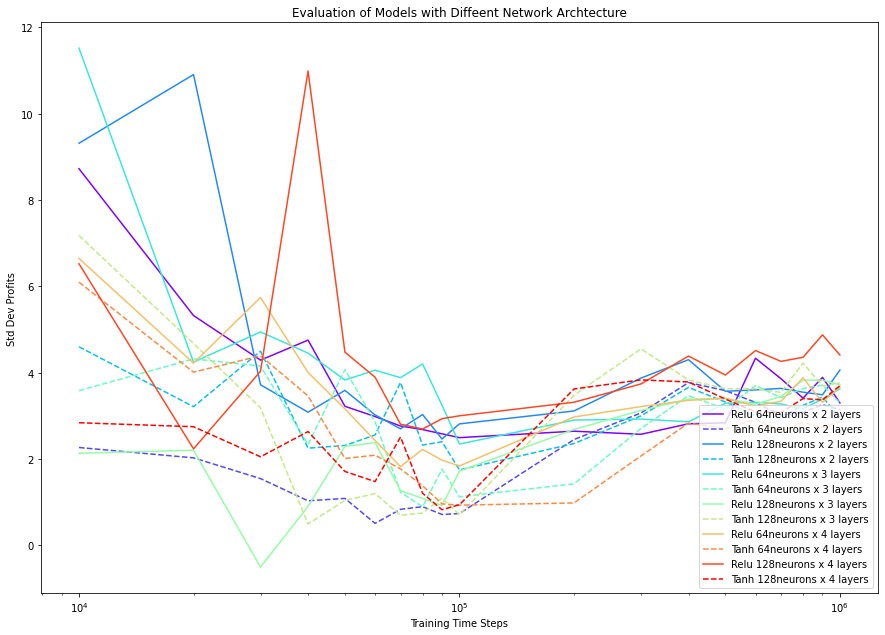

In [97]:
def plot_net_archs(xs, name_to_scores, title, std=False):
    colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    
    for name, c in zip(name_to_scores.keys(), colors):
        act, num_neuron, num_layer = name
        linestyle='-' if act == "Relu" else "--"
        if std:
            scores = name_to_scores[name][1]
        else:
            scores = name_to_scores[name][0]
        plt.plot(xs, scores, label=str(act)+" "+str(num_neuron)+"neurons x "+str(num_layer)+" layers",
                     linestyle=linestyle, color=c) # print mean rewards

    plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel("Training Time Steps")
    if std:
        plt.ylabel("Standard Deviation Profits")
    else:
        plt.ylabel("Mean Profits")
    plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(15, 10.5)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()
    

plot_net_archs(time_steps, name_to_scores, "Evaluation of Models with Diffeent Network Archtecture", std=False)

In [102]:
# plot % of EVAgent
percent = [0, 10, 20, 30, 40, 60, 80, 100]
for p in percent:
    EVAgent_percentage = p/100
    SAVE_PATH= './model_checkpoints/plot_EVAgent_percent/' + str(p) +'/'

    model_path = join(SAVE_PATH, "rl_model_"+ str(1000000) + "_steps")

   
    model = PPO2.load(model_path)

    # Evaluate the agent
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
    print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)


    name_to_scores[p] = (mean_reward, std_reward)

./model_checkpoints/plot_EVAgent_percent/0/rl_model_1000000_steps  mean_reward:  -0.3553330078125  std_reward:  1.976180906029911
./model_checkpoints/plot_EVAgent_percent/10/rl_model_1000000_steps  mean_reward:  2.0710146484375  std_reward:  4.285713919702948
./model_checkpoints/plot_EVAgent_percent/20/rl_model_1000000_steps  mean_reward:  2.955158203125  std_reward:  3.5592307584204548
./model_checkpoints/plot_EVAgent_percent/30/rl_model_1000000_steps  mean_reward:  2.93250390625  std_reward:  3.338549415470615
./model_checkpoints/plot_EVAgent_percent/40/rl_model_1000000_steps  mean_reward:  2.005501953125  std_reward:  3.6438497201931774
./model_checkpoints/plot_EVAgent_percent/60/rl_model_1000000_steps  mean_reward:  3.2611728515625  std_reward:  3.3230619665870553
./model_checkpoints/plot_EVAgent_percent/80/rl_model_1000000_steps  mean_reward:  3.2873486328125  std_reward:  3.181147117071535
./model_checkpoints/plot_EVAgent_percent/100/rl_model_1000000_steps  mean_reward:  3.341844

In [103]:
with open("name_to_scores_EVAgent_percent", 'wb') as f:
    pickle.dump(name_to_scores, f)

In [187]:
with open("name_to_scores_EVAgent_percent", 'rb') as f:
    name_to_scores = pickle.load(f)

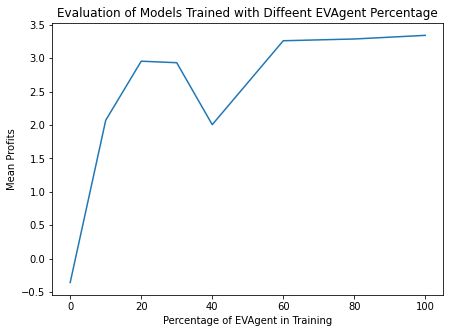

In [188]:
def plot_mean(name_to_scores, title, xlabel, plot_std=False):
    # colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    scores = []
    stds = []
    xs = []
    for name in name_to_scores.keys():
        score, std = name_to_scores[name]
        scores.append(score)
        stds.append(std)
        xs.append(name)
    
    plt.plot(xs, scores, linestyle="-") 
    plt.ylabel("Mean Profits")
    if plot_std:
        plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], 
                         [score - std for score, std in zip(scores, stds)], facecolor='yellow', alpha=0.1)
        plt.ylabel("Mean Profits With Standard Deviation Interval")
        
    # plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel(xlabel)
    
    # plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()
    

plot_mean(name_to_scores, "Evaluation of Models Trained with Diffeent EVAgent Percentage", 
          "Percentage of EVAgent in Training", plot_std=False)

In [124]:
# plot different transaction history length
length = [0, 1, 2, 4, 6, 8]
for l in length:
    TRANSACTION_HISTORY_SIZE = l
    SAVE_PATH= './model_checkpoints/plot_trans_hist_size/' + str(l) +'/'
    model_path = join(SAVE_PATH, "rl_model_"+ str(1000000) + "_steps")

   
    model = PPO2.load(model_path)

    env = TradingGameEnv.TradingGameEnv(player_count = NUM_PLAYERS, other_agent_list = agents,
            seq_per_day = SEQ_PER_DAY, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT,
            random_seq = True, self_play = False, obs_transaction_history_size=TRANSACTION_HISTORY_SIZE, eval=True)
    
    # Evaluate the agent
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
    print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)


    name_to_scores[l] = (mean_reward, std_reward)

./model_checkpoints/plot_trans_hist_size/0/rl_model_1000000_steps  mean_reward:  0.413986328125  std_reward:  4.018857823601817
./model_checkpoints/plot_trans_hist_size/1/rl_model_1000000_steps  mean_reward:  2.281669921875  std_reward:  3.4136202261278594
./model_checkpoints/plot_trans_hist_size/2/rl_model_1000000_steps  mean_reward:  3.0233505859375  std_reward:  3.3425362286824796
./model_checkpoints/plot_trans_hist_size/4/rl_model_1000000_steps  mean_reward:  3.31951171875  std_reward:  3.414341050799185
./model_checkpoints/plot_trans_hist_size/6/rl_model_1000000_steps  mean_reward:  2.57050390625  std_reward:  4.13555391229322
./model_checkpoints/plot_trans_hist_size/8/rl_model_1000000_steps  mean_reward:  1.8881708984375  std_reward:  3.926315593958667


In [125]:
with open("name_to_scores_trans_length", 'wb') as f:
    pickle.dump(name_to_scores, f)

In [ ]:
with open("name_to_scores_trans_length", 'rb') as f:
    name_to_scores = pickle.load(f)

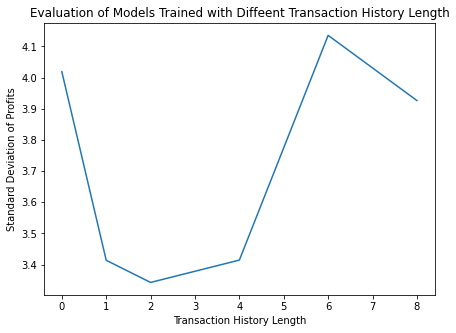

In [135]:
def plot_mean(name_to_scores, title, xlabel, plot_std=False):
    # colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    scores = []
    stds = []
    xs = []
    for name in name_to_scores.keys():
        score, std = name_to_scores[name]
        scores.append(score)
        stds.append(std)
        xs.append(name)
    
    plt.plot(xs, scores, linestyle="-") 
    plt.ylabel("Mean Profits")
    if plot_std == True:
        plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], 
                         [score - std for score, std in zip(scores, stds)], facecolor='yellow', alpha=0.1)
        plt.ylabel("Mean Profits With Standard Deviation Interval")
        
    # plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel(xlabel)
    
    # plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()
    

plot_mean(name_to_scores, "Evaluation of Models Trained with Diffeent Transaction History Length", 
          "Transaction History Length", plot_std=False)

In [148]:
# plot model bank update frequency
freq = [1, 5, 10, 100, 1000]
for f in freq:
    SELF_COPY_FREQ = f
    SAVE_PATH= './model_checkpoints/plot_model_bank_update_freq/' + str(f) +'/'
    model_path = join(SAVE_PATH, "rl_model_"+ str(1000000) + "_steps")

   
    model = PPO2.load(model_path)

    # Evaluate the agent
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
    print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)


    name_to_scores[f] = (mean_reward, std_reward)

./model_checkpoints/plot_model_bank_update_freq/1/rl_model_1000000_steps  mean_reward:  2.7181650390625  std_reward:  3.897847586444452
./model_checkpoints/plot_model_bank_update_freq/5/rl_model_1000000_steps  mean_reward:  2.4185  std_reward:  4.225280560321502
./model_checkpoints/plot_model_bank_update_freq/10/rl_model_1000000_steps  mean_reward:  2.8631650390625  std_reward:  3.629429268860897
./model_checkpoints/plot_model_bank_update_freq/100/rl_model_1000000_steps  mean_reward:  2.587  std_reward:  3.8221978850765583
./model_checkpoints/plot_model_bank_update_freq/1000/rl_model_1000000_steps  mean_reward:  0.8924853515625  std_reward:  3.9392199726366877


In [149]:
with open("name_to_scores_bank_freq", 'wb') as f:
    pickle.dump(name_to_scores, f)

In [ ]:
with open("name_to_scores_bank_freq", 'rb') as f:
    name_to_scores = pickle.load(f)

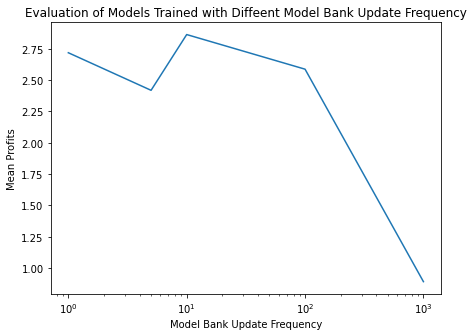

In [155]:
def plot_mean(name_to_scores, title, xlabel, plot_std=False):
    # colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    scores = []
    stds = []
    xs = []
    for name in name_to_scores.keys():
        score, std = name_to_scores[name]
        scores.append(score)
        stds.append(std)
        xs.append(name)
    
    plt.plot(xs, scores, linestyle="-") 
    plt.ylabel("Mean Profits")
    if plot_std == True:
        plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], 
                         [score - std for score, std in zip(scores, stds)], facecolor='yellow', alpha=0.1)
        plt.ylabel("Mean Profits With Standard Deviation Interval")
        
    # plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel(xlabel)
    
    plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()
    

plot_mean(name_to_scores, "Evaluation of Models Trained with Diffeent Model Bank Update Frequency", 
          "Model Bank Update Frequency", plot_std=False)

In [161]:
# plot dynamic evaluation
dynamic = [True, False]
for d in dynamic:
    DYNAMIC_EVAL = d
    SAVE_PATH= './model_checkpoints/plot_dynamic_eval/' + str(d) +'/'
        
    trained_models = [join(SAVE_PATH, "rl_model_"+ str(f) + "_steps") for f in time_steps]

    mean = []
    std = []
            
    for model_path in trained_models:
        model = PPO2.load(model_path)

        # Evaluate the agent
        mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
        mean.append(mean_reward)
        std.append(std_reward)
        print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)
            
            
    name_to_scores[d] = (mean, std)

./model_checkpoints/plot_dynamic_eval/True/rl_model_10000_steps  mean_reward:  -8.898171875  std_reward:  13.863301910170573
./model_checkpoints/plot_dynamic_eval/True/rl_model_20000_steps  mean_reward:  -1.5431640625  std_reward:  3.0252898662182677
./model_checkpoints/plot_dynamic_eval/True/rl_model_30000_steps  mean_reward:  -3.6618232421875  std_reward:  5.556951307112508
./model_checkpoints/plot_dynamic_eval/True/rl_model_40000_steps  mean_reward:  -2.9003427734375  std_reward:  4.219648555724672
./model_checkpoints/plot_dynamic_eval/True/rl_model_50000_steps  mean_reward:  -3.0796796875  std_reward:  6.094519541780521
./model_checkpoints/plot_dynamic_eval/True/rl_model_60000_steps  mean_reward:  -1.79434375  std_reward:  3.7854968747826563
./model_checkpoints/plot_dynamic_eval/True/rl_model_70000_steps  mean_reward:  -0.8138349609375  std_reward:  3.956683285182029
./model_checkpoints/plot_dynamic_eval/True/rl_model_80000_steps  mean_reward:  0.135146484375  std_reward:  3.669905

In [162]:
with open("name_to_scores_dynamic_eval", 'wb') as f:
    pickle.dump(name_to_scores, f)

In [ ]:
with open("name_to_scores_dynamic_eval", 'rb') as f:
    name_to_scores = pickle.load(f)

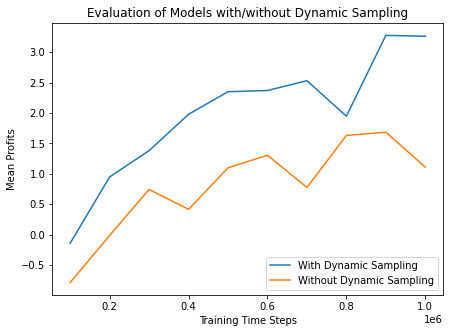

In [179]:
time_steps = [              100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]

def plot_dynamic_eval(xs, name_to_scores, title, std=False, std_interval=False):
    colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    
    if std:
        plt.ylabel("Standard Deviation Profits")
    else:
        plt.ylabel("Mean Profits")
        
    for name, c in zip(name_to_scores.keys(), colors):
        if std:
            scores = name_to_scores[name][1][9:]
        else:
            scores = name_to_scores[name][0][9:]
        plt.plot(xs, scores, label="With Dynamic Sampling" if name else "Without Dynamic Sampling",
                     linestyle="-") # print mean rewards
        
        if std_interval == True:
            stds = name_to_scores[name][1][9:]
            plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], 
                             [score - std for score, std in zip(scores, stds)], facecolor=c, alpha=0.1)
            plt.ylabel("Mean Profits With Standard Deviation Interval")
        
    plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel("Training Time Steps")
    # plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()
    

plot_dynamic_eval(time_steps, name_to_scores, "Evaluation of Models with/without Dynamic Sampling", 
                  std=False, std_interval=False)

In [5]:
# plot more cards
cards = [20, 40, 60, 80, 100]
for c in cards:
    # POLICY_TYPE = 'MlpPolicyRelu128_3'
    SAVE_PATH= './model_checkpoints/plot_cards/' + str(c) +'/'

    model_path = join(SAVE_PATH, "rl_model_"+ str(1000000) + "_steps")
   
    model = PPO2.load(model_path)
    
    CARDS_PER_SUIT = c
    BETTING_MARGIN = CARDS_PER_SUIT*CARDS_PER_SUIT/100
    HAND_COUNT = (int) ((CARDS_PER_SUIT)/2*SUIT_COUNT/NUM_PLAYERS)

    PUBLIC_CARDS_COUNT = CARDS_PER_SUIT*SUIT_COUNT - HAND_COUNT*NUM_PLAYERS


    # add 1 baseline agent
    agents = []
    agents.append(baseline_agents.EVAgent(agent_idx = 1, num_players = NUM_PLAYERS, betting_margin = BETTING_MARGIN, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT, public_cards_count = PUBLIC_CARDS_COUNT))


    env = TradingGameEnv.TradingGameEnv(player_count = NUM_PLAYERS, other_agent_list = agents,
            seq_per_day = SEQ_PER_DAY, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT,
            random_seq = True, self_play = False, obs_transaction_history_size=TRANSACTION_HISTORY_SIZE, eval=True)
    
    # Evaluate the agent
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
    print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)


    name_to_scores[c] = (mean_reward, std_reward)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



./model_checkpoints/plot_cards/20/rl_model_1000000_steps  mean_reward:  -0.0669345703125  std_reward:  19.308506460473854
./model_checkpoints/plot_cards/40/rl_model_1000000_steps  mean_reward:  -9.658669921875  std_reward:  41.444466523615546
./model_checkpoints/plot_cards/60/rl_model_1000000_steps  mean_reward:  -1008.2092458496094  std_reward:  847.7846732915655
./model_checkpoints/plot_cards/80/rl_model_1000000_steps  mean_reward:  -1199.548666015625  std_reward:  733.1683810441415
./model_checkpoints/plot_cards/100/rl_model_1000000_steps  mean_reward:  0.0  std_reward:  0.0


In [11]:
with open("name_to_scores_more_cards", 'wb') as f:
    pickle.dump(name_to_scores, f)

In [ ]:
with open("name_to_scores_more_cards", 'rb') as f:
    name_to_scores = pickle.load(f)

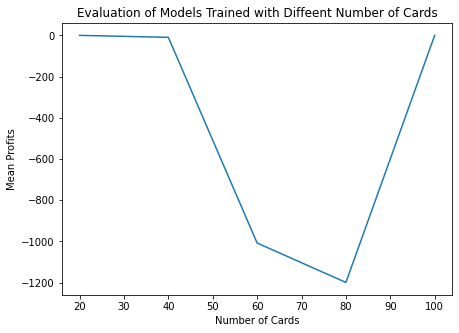

In [6]:
def plot_mean(name_to_scores, title, xlabel, plot_std=False):
    # colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    scores = []
    stds = []
    xs = []
    for name in name_to_scores.keys():
        score, std = name_to_scores[name]
        scores.append(score)
        stds.append(std)
        xs.append(name)
    
    plt.plot(xs, scores, linestyle="-") 
    plt.ylabel("Mean Profits")
    if plot_std == True:
        plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], 
                         [score - std for score, std in zip(scores, stds)], facecolor='yellow', alpha=0.1)
        plt.ylabel("Mean Profits With Standard Deviation Interval")
        
    # plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel(xlabel)
    
    # plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()
    

plot_mean(name_to_scores, "Evaluation of Models Trained with Diffeent Number of Cards", 
          "Number of Cards", plot_std=False)

In [16]:
# plot more players
players = [2, 3, 4, 5, 6, 10, 15]
for p in players:
    # POLICY_TYPE = 'MlpPolicyRelu128_3'
    SAVE_PATH= './model_checkpoints/plot_players/' + str(p) +'/'
    model_path = join(SAVE_PATH, "rl_model_"+ str(1000000) + "_steps")
    model = PPO2.load(model_path)
    
    NUM_PLAYERS = p
    CARDS_PER_SUIT = 30
    BETTING_MARGIN = CARDS_PER_SUIT*CARDS_PER_SUIT/100
    HAND_COUNT = (int) ((CARDS_PER_SUIT)/2*SUIT_COUNT/NUM_PLAYERS)

    PUBLIC_CARDS_COUNT = CARDS_PER_SUIT*SUIT_COUNT - HAND_COUNT*NUM_PLAYERS


    # add baseline agents
    agents = []
    for i in range(p-1):
        agents.append(baseline_agents.EVAgent(agent_idx = i+1, num_players = NUM_PLAYERS, betting_margin = BETTING_MARGIN, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT, public_cards_count = PUBLIC_CARDS_COUNT))

    
    env = TradingGameEnv.TradingGameEnv(player_count = NUM_PLAYERS, other_agent_list = agents,
            seq_per_day = SEQ_PER_DAY, cards_per_suit = CARDS_PER_SUIT, player_hand_count = HAND_COUNT,
            random_seq = True, self_play = False, obs_transaction_history_size=TRANSACTION_HISTORY_SIZE, eval=True)
    
    # Evaluate the agent
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES)
    print(model_path, " mean_reward: ", mean_reward, " std_reward: ", std_reward)


    name_to_scores[p] = (mean_reward, std_reward)

./model_checkpoints/plot_players/2/rl_model_1000000_steps  mean_reward:  -14.899482421875  std_reward:  54.45576410584542
./model_checkpoints/plot_players/3/rl_model_1000000_steps  mean_reward:  2.009271484375  std_reward:  16.57709091398467
./model_checkpoints/plot_players/4/rl_model_1000000_steps  mean_reward:  -1.229525390625  std_reward:  15.440036084833498
./model_checkpoints/plot_players/5/rl_model_1000000_steps  mean_reward:  -0.0784345703125  std_reward:  1.8295691407452956
./model_checkpoints/plot_players/6/rl_model_1000000_steps  mean_reward:  0.0  std_reward:  0.0
./model_checkpoints/plot_players/10/rl_model_1000000_steps  mean_reward:  0.044375  std_reward:  3.345848582105144
./model_checkpoints/plot_players/15/rl_model_1000000_steps  mean_reward:  0.0  std_reward:  0.0


In [17]:
with open("name_to_scores_more_players", 'wb') as f:
    pickle.dump(name_to_scores, f)

In [ ]:
with open("name_to_scores_more_players", 'rb') as f:
    name_to_scores = pickle.load(f)

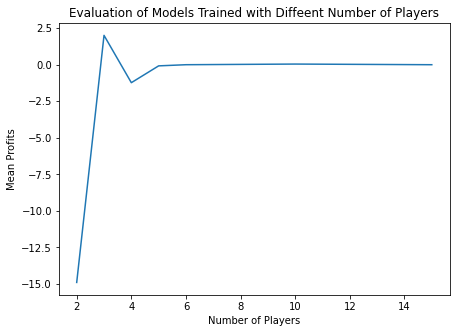

In [18]:
def plot_mean(name_to_scores, title, xlabel, plot_std=False):
    # colors = cm.rainbow(np.linspace(0, 1, len(name_to_scores.keys())))
    scores = []
    stds = []
    xs = []
    for name in name_to_scores.keys():
        score, std = name_to_scores[name]
        scores.append(score)
        stds.append(std)
        xs.append(name)
    
    plt.plot(xs, scores, linestyle="-") 
    plt.ylabel("Mean Profits")
    if plot_std == True:
        plt.fill_between(xs, [score + std for score, std in zip(scores, stds)], 
                         [score - std for score, std in zip(scores, stds)], facecolor='yellow', alpha=0.1)
        plt.ylabel("Mean Profits With Standard Deviation Interval")
        
    # plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel(xlabel)
    
    # plt.xscale('log')
    
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    # fig.savefig('test2png.png', dpi=100)

    plt.show()
    

plot_mean(name_to_scores, "Evaluation of Models Trained with Diffeent Number of Players", 
          "Number of Players", plot_std=False)